![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV


In [124]:
# read and preview the data
df = pd.read_csv('rental_info.csv')
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [125]:
# check the data for missing values
df.isnull().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [126]:
#show statistical summary of the data
df.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [127]:
#check info of the columns of the dataframe and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [128]:
#change column one and two to the appropraite datatype

df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

In [129]:
#create new column rental_length_days from return_date and rental_date

df['rental_length_days'] = (df['return_date'] - df['rental_date']).dt.days;
df['rental_length_days']


0        3
1        2
2        7
3        2
4        4
        ..
15856    6
15857    4
15858    9
15859    8
15860    6
Name: rental_length_days, Length: 15861, dtype: int64

In [130]:
# create dummy variables columns from special_features using deleted scenes and behind the scenes

special_features_dummies = df['special_features'].str.replace(r'[{}"]', '', regex=True)
special_features_dummies = special_features_dummies.str.get_dummies(sep=',');

df["deleted_scenes"] = special_features_dummies["Deleted Scenes"];
df["behind_the_scenes"] = special_features_dummies["Behind the Scenes"]

print(df[["deleted_scenes", "behind_the_scenes"]]);

       deleted_scenes  behind_the_scenes
0                   0                  1
1                   0                  1
2                   0                  1
3                   0                  1
4                   0                  1
...               ...                ...
15856               1                  1
15857               1                  1
15858               1                  1
15859               1                  1
15860               1                  1

[15861 rows x 2 columns]


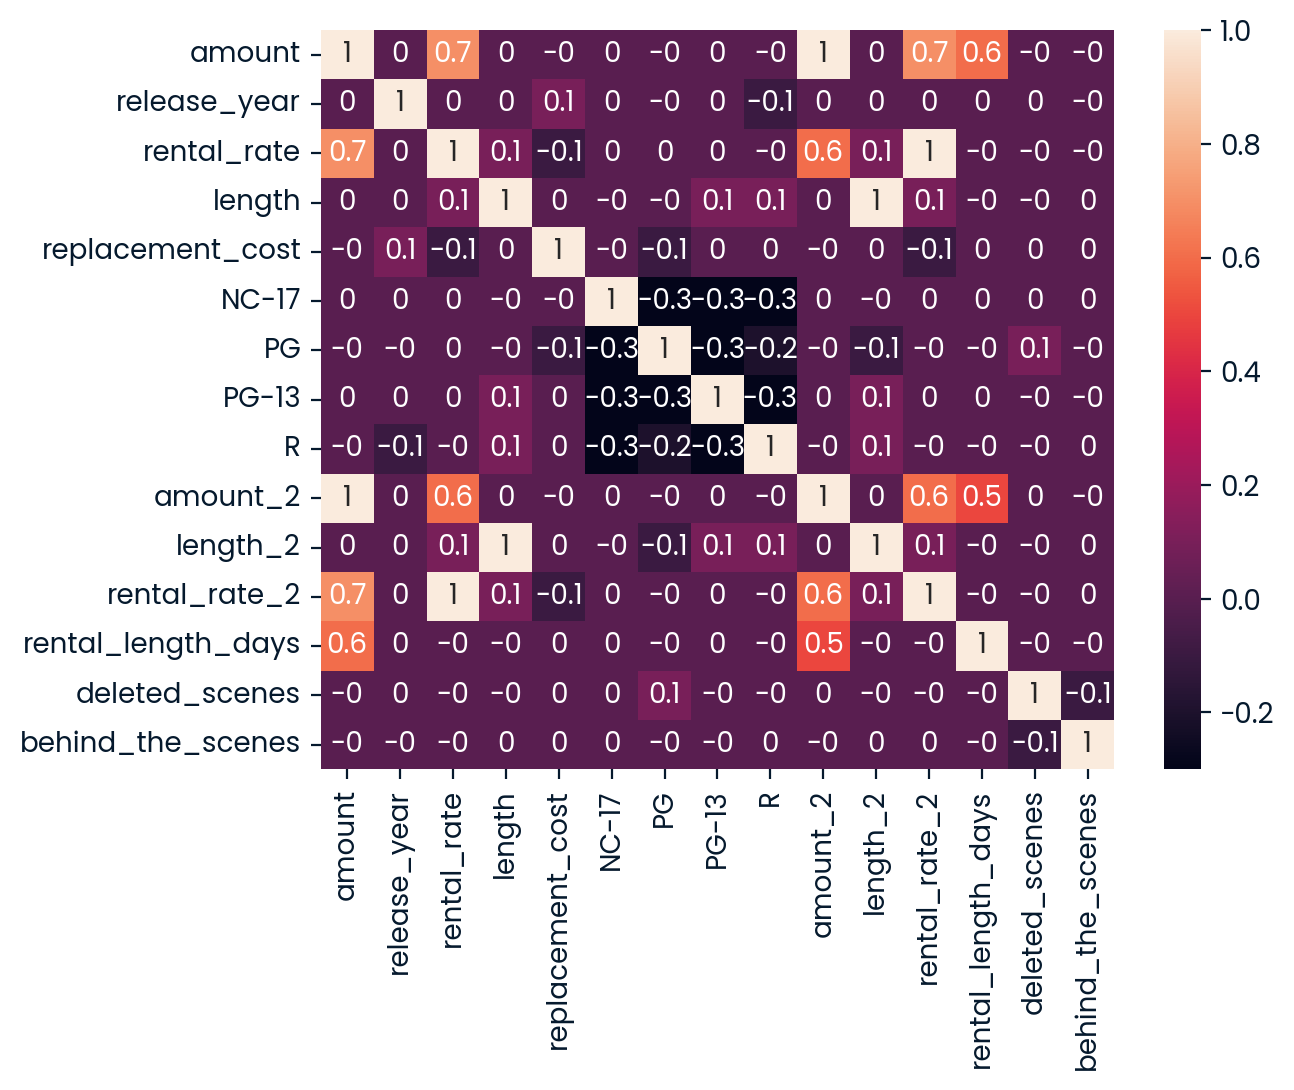

In [131]:
#use sns heatmap visualize linear relationship between predictors and target feature

sns.heatmap(round(df.corr(),1), annot=True)
plt.show()

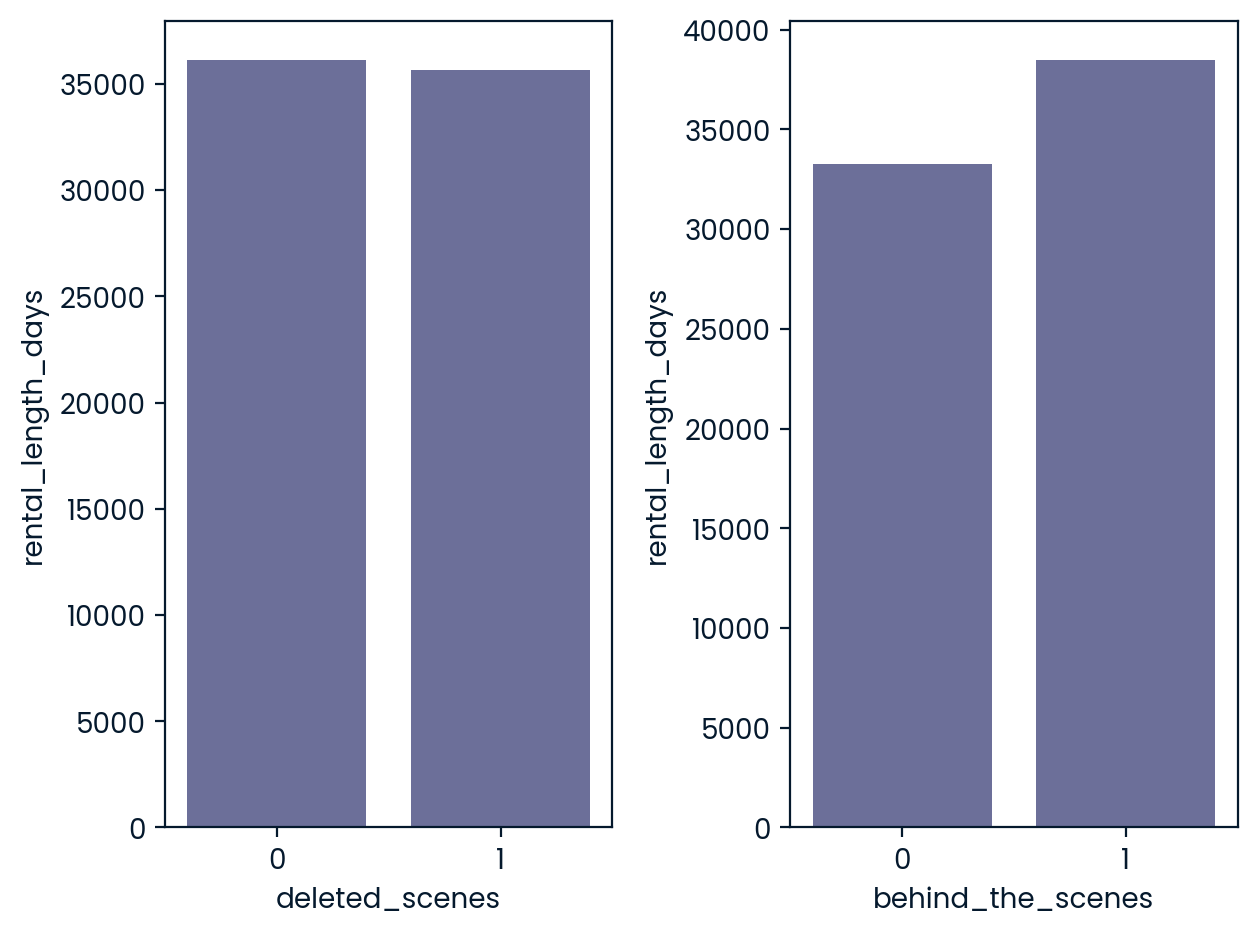

In [132]:
#visualization for relationship between special features and total rental_length_days for each

rental_by_deleted_scenes = df.groupby('deleted_scenes').sum()
rental_by_behind_the_scenes = df.groupby('behind_the_scenes').sum()

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

sns.barplot(data=rental_by_deleted_scenes, x='deleted_scenes', y='rental_length_days', ax=ax1)
sns.barplot(data=rental_by_behind_the_scenes, x='behind_the_scenes', y='rental_length_days', ax=ax2)
plt.tight_layout()
plt.show()
                               

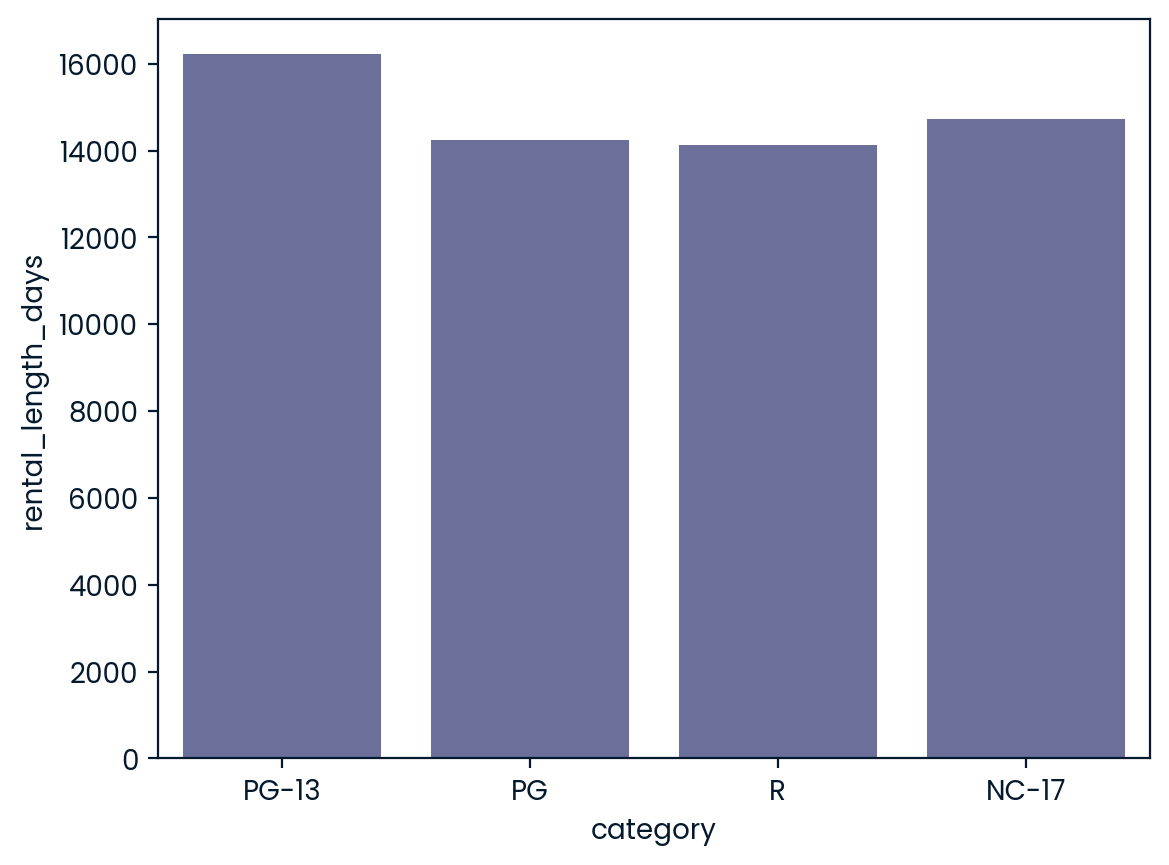

In [133]:
#plotting total rental_length_days against each movie category

rental_days_by_movie_category = pd.DataFrame();

for category in ['PG-13', 'PG', 'R', 'NC-17']:
    rental_by_category = df.groupby(category).sum();
    total_rental_days = rental_by_category['rental_length_days'].loc[1]
    #append each row the rental_days_by_movie_category dataframe
    rental_days_by_movie_category = rental_days_by_movie_category.append({'category': category, 'rental_length_days': total_rental_days}, ignore_index=True);

sns.barplot(data=rental_days_by_movie_category, y='rental_length_days', x='category');

In [134]:
#create new dataframe for predictor features and target features

X = df.drop(['replacement_cost', 'release_year', 'special_features', 'rental_length_days'], axis=1, inplace=False);
X[['return_date', 'rental_date']] = X[['return_date', 'rental_date']].astype('int64');

y = df['rental_length_days'];

SEED = 9;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED);

In [135]:
#perform hyperparameter tuning to find the best model hyperparameters

dt = GradientBoostingRegressor();

params_dt = {
    'max_depth': [3,4,5,6],
    'max_features': [0.2, 0.4, 0.6, 0.8],
    'n_estimators': [250, 350, 300, 325],
    'subsample': [0.4, 0.5, 0.6, 0.7]
}

#grid_dt = GridSearchCV(estimator=dt,
                      #param_grid=params_dt,
                      #scoring='neg_mean_squared_error',
                      #cv=5,
                      #n_jobs=-1);

#grid_dt.fit(X_train, y_train);
#best_params = grid_dt.best_params_;
#best_score = -grid_dt.best_score_;

#print('Best Parameters:', best_params, ' Best Score:', best_score);


In [136]:
#recommend best performing model

best_model = GradientBoostingRegressor(max_depth=4, 
                                 subsample=0.7,
                                 min_samples_leaf=35,
                                 max_features=0.6,
                                 n_estimators=300,
                                 random_state=SEED
                                 )
best_model.fit(X_train, y_train);
y_pred = best_model.predict(X_test);

best_mse = MSE(y_pred, y_test)

print(best_mse);

0.3990987029807245
